# CNN (Convolutional Neural Networks)

In [1]:
%matplotlib inline

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from IPython.display import YouTubeVideo
from PIL import Image
from tqdm import tqdm

In [2]:
def plot(X):
    plt.imshow(X, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')

def apply_filter(X, F):
    x, y = X.shape
    filter_x, filter_y = F.shape
    X_with_filter = np.zeros(shape=(x - filter_x, y - filter_y))

    for i in range(x - filter_x):
        for j in range(y - filter_y):
            X_with_filter[i, j] = (X[i:(i+filter_x), j:(j+filter_y)] * F).sum()
    
    return X_with_filter

In [3]:
!curl https://raw.githubusercontent.com/trokas/ai_primer/master/img/castle.jpg --output castle.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9217  100  9217    0     0  16147      0 --:--:-- --:--:-- --:--:--     0:--:-- --:--:-- 16141


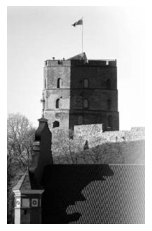

In [4]:
img = Image.open('castle.jpg')
img.load()
X = np.asarray(img, dtype="int32") / 255
# X = X.mean(axis=2) / 255
plot(X)

## Filters

It turns out that by sliding simple matrix over an image we can achieve neat things.

Multiplication by sliding matrix can be thought of as **filter**.

<img src="https://cdn-images-1.medium.com/max/900/1*7S266Kq-UCExS25iX_I_AQ.png" style="width: 70%"/>

### Simple box blur

[[0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]]


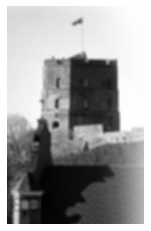

In [5]:
F = np.ones(shape=(5, 5)) / 25
print(F)
plot(apply_filter(X, F))

### Line detection

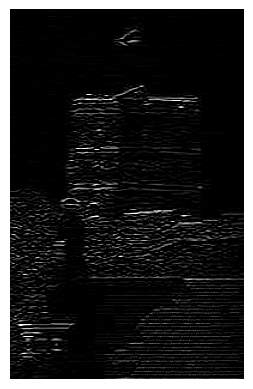

In [6]:
F = np.array([[-1, -1, -1],
              [ 2,  2,  2],
              [-1, -1, -1]])
plot(apply_filter(X, F))

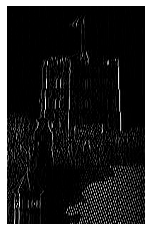

In [6]:
F = np.array([[-1, 2, -1],
              [-1, 2, -1],
              [-1, 2, -1]])
plot(apply_filter(X, F))

### Edge detection

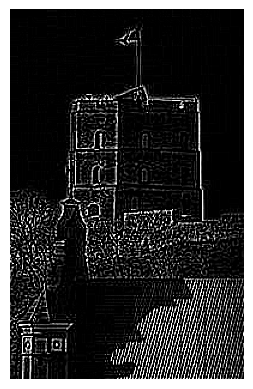

In [8]:
F = np.array([[-1, -1, -1],
              [-1,  8, -1],
              [-1, -1, -1]])
plot(apply_filter(X, F))

### The Sobel Edge Operator

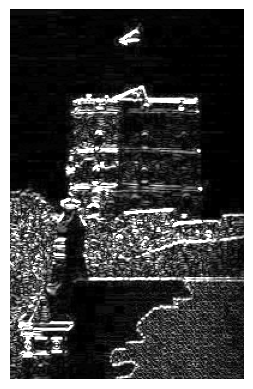

In [9]:
F_horizontal = np.array([[-1, -2, -1],
                         [ 0,  0,  0],
                         [ 1,  2,  1]])
F_vertical = np.array([[-1, -2, -1],
                       [ 0,  0,  0],
                       [ 1,  2,  1]])
plot(np.sqrt(apply_filter(X, F_horizontal)**2 + apply_filter(X, F_vertical)**2))

## Filters in PyTorch

CNN's in PyTorch do exactly the same thing as we did above, for example let's replicate line detection filter. First let's inititialize convolutional layer and pass input just to make sure that it works with random weights. Note that we need to add some axes to make it work.

In [12]:
conv = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, padding='valid', bias=True)
X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(0)
X_tensor.shape, conv(X_tensor).shape

(torch.Size([1, 312, 198]), torch.Size([10, 310, 196]))

In [14]:
conv.weight

Parameter containing:
tensor([[[[-0.1508, -0.0464, -0.1354],
          [-0.1364, -0.2361,  0.0743],
          [-0.0529, -0.2670,  0.0117]]],


        [[[ 0.2436,  0.2759, -0.0394],
          [-0.1646,  0.0078, -0.2532],
          [-0.1980, -0.2158, -0.1192]]],


        [[[ 0.2487, -0.1921, -0.1824],
          [ 0.1712,  0.1333,  0.2521],
          [ 0.2487,  0.2421, -0.0135]]],


        [[[-0.1914, -0.1077,  0.1180],
          [-0.2315,  0.2364,  0.2931],
          [ 0.0320, -0.1036, -0.1810]]],


        [[[ 0.0436,  0.1452, -0.2886],
          [ 0.0277,  0.1534,  0.1859],
          [-0.1660, -0.1428,  0.0566]]],


        [[[-0.0977,  0.2159, -0.0009],
          [-0.2093, -0.0161, -0.3230],
          [-0.2472,  0.2128, -0.2956]]],


        [[[-0.0464, -0.1098, -0.2199],
          [ 0.2786, -0.2222, -0.2046],
          [-0.3178,  0.0072,  0.2969]]],


        [[[-0.1137,  0.2458, -0.1020],
          [-0.2607,  0.3000, -0.1036],
          [-0.1834, -0.2743,  0.1842]]],


        [[

Now let's manually set weights.

In [11]:
F = np.array([[-1, -1, -1],
              [ 2,  2,  2],
              [-1, -1, -1]])

# Add in_channels and out_channels dimensions
F_tensor = torch.tensor(F, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  
conv.weight = nn.Parameter(F_tensor)  # Set the weights
conv.bias = nn.Parameter(torch.tensor([0.0]))  # Set the bias

Let's check if outputs looks as expected.

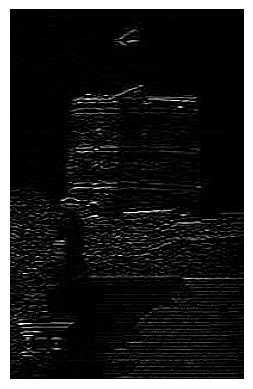

In [62]:
plot(conv(X_tensor)[0].detach().numpy())

## CNN

### Super short history

In 1964 Hubel and Wiesel discovered some interesting facts about cats’ visual cortex (see [original video](https://www.youtube.com/watch?v=IOHayh06LJ4)). It turns out that there are specific neurons which react to different shapes, also it looks like there is hierarchical structures and basic forms are used as a basic building blocks for later neurons.

<img width=30% src="https://www.researchgate.net/profile/Anh_Nguyen44/publication/335707980/figure/fig1/AS:803803662127107@1568653135830/Fig-In-the-classic-neuroscience-experiment-Hubel-and-Wiesel-discovered-a-cats-visual.png"/>

In 1979 neocognitron was proposed by Kunihiko Fukushima and in 1980s CNN were finally developed. Le Couns group made them work on MNIST by intoducing LeNet-5 architecture.

<img width=70% src="https://miro.medium.com/max/4348/1*PXworfAP2IombUzBsDMg7Q.png"/>

Even though LeNet-5 was used for character recognition in some banks from 1980s, next real advancement came only in 2012 with AlexNet which won ImageNet competition at the time and was comprised of 60M parameters (compared to 60k used in LeNet-5). From that point CNN's only grew in size (see [top 10 architectures](https://towardsdatascience.com/illustrated-10-cnn-architectures-95d78ace614d)).

<img width=60% src="https://www.researchgate.net/profile/Sherif_Shehata2/publication/308880040/figure/fig3/AS:413548556636165@1475609067864/An-illustration-of-the-architecture-of-AlexNet-deep-convolutional-neural-network.png"/>

It turns out that CNN's do a similar thing as neurons in Hubel and Wiesels cortex model - lower levels detect simple shapes and in later layers they are combined.


### Implementation

Just as with simple fully connected networks you can try to write logic from scratch before jumping to using PyTorch or other ML library just to get deeper understanding of what is going on, for example see [this post](https://towardsdatascience.com/lets-code-convolutional-neural-network-in-plain-numpy-ce48e732f5d5).

Let's load MNIST dataset.

In [15]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.003, momentum=0.9)

In [18]:
epochs = 10
losses = []
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        optimizer.zero_grad()
        
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    losses.append(running_loss / len(trainloader))
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")

Epoch 1, Loss: 0.6482619126833705
Epoch 2, Loss: 0.28690067095670113
Epoch 3, Loss: 0.22519314378849478
Epoch 4, Loss: 0.184173308003114
Epoch 5, Loss: 0.15617873830033707
Epoch 6, Loss: 0.13419466763774532
Epoch 7, Loss: 0.11694671276873395
Epoch 8, Loss: 0.10290440029180697
Epoch 9, Loss: 0.09305142814210102
Epoch 10, Loss: 0.08319734508044589


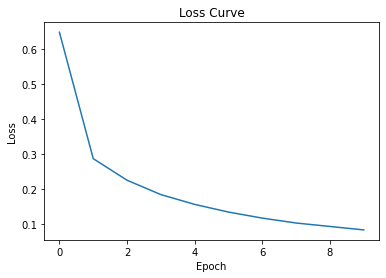

In [19]:
plt.plot(range(epochs), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

*Reminder:* using FCN we had 96.36% on test set.

In [79]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')

Accuracy of the network on the 10000 test images: 97.75%


**TASK:** add validation loss to the training loop and plot both curves after training.

## What's next?

**NOTE:** LONG TRAINING TIME!

For faster training you can use [colab](https://colab.research.google.com/), just change it GPU mode by setting it at Edit -> Notebook settings -> Hardware accelerator.

There are multiple other tricks (Dropout, MaxPooling, ...) which can increse performance even more, but general CNN principle is still leading solution in image recognition.

We will look at these tricks in datail during the lecture, for now let's see what they can do.

In [86]:
# Check if CUDA is available, otherwise check for MPS, else use CPU
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


In [87]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.bn3 = nn.BatchNorm2d(32)
        # Dense layers
        self.fc1 = nn.Linear(32 * 12 * 12, 128)   # Adjusted for the output size after conv and pooling layers
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.bn3(x)
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

net = Net().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=3e-4)

In [91]:
epochs = 10
losses = []
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in tqdm(trainloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    losses.append(running_loss / len(trainloader))
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")

100%|█████████████████████████████████████████| 938/938 [00:12<00:00, 72.95it/s]


Epoch 1, Loss: 0.04964635392683789


100%|█████████████████████████████████████████| 938/938 [00:11<00:00, 78.75it/s]


Epoch 2, Loss: 0.0319404945256616


100%|█████████████████████████████████████████| 938/938 [00:11<00:00, 79.73it/s]


Epoch 3, Loss: 0.02221851827272291


100%|█████████████████████████████████████████| 938/938 [00:11<00:00, 79.23it/s]


Epoch 4, Loss: 0.016258836341969386


100%|█████████████████████████████████████████| 938/938 [00:12<00:00, 77.78it/s]


Epoch 5, Loss: 0.013607240666595502


100%|█████████████████████████████████████████| 938/938 [00:12<00:00, 78.03it/s]


Epoch 6, Loss: 0.01015313278053167


100%|█████████████████████████████████████████| 938/938 [00:11<00:00, 78.55it/s]


Epoch 7, Loss: 0.008300642033510981


100%|█████████████████████████████████████████| 938/938 [00:11<00:00, 79.11it/s]


Epoch 8, Loss: 0.00605639193290476


100%|█████████████████████████████████████████| 938/938 [00:11<00:00, 79.59it/s]


Epoch 9, Loss: 0.005098030387810556


100%|█████████████████████████████████████████| 938/938 [00:11<00:00, 79.03it/s]

Epoch 10, Loss: 0.005710192270729889


In [94]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')

Accuracy of the network on the 10000 test images: 98.97%


Usually in blogs and books you will find implementation which uses dropout between CNN layers, but there is well known [critique](https://www.kdnuggets.com/2018/09/dropout-convolutional-networks.html) of this technique.

## So where are we on MNIST?

We tried RF, DNN and CNN for MNIST and managed to reproduced some of the key benchmarks out there

<img src="https://paper-attachments.dropbox.com/s_2E4854D97CFCA11CB3874DE15FA048AD21CE628C357A5C14D6A303FEC847FA36_1604825782553_image.png" style="width: 70%"/>

## U-Net

There are various architectures in which CNNs are used. As an example let's dig into U-Net which can be really useful when the goal is to perform image segmentation. Instead of using images we will try to use it for peak area estimation for noisy sequences.

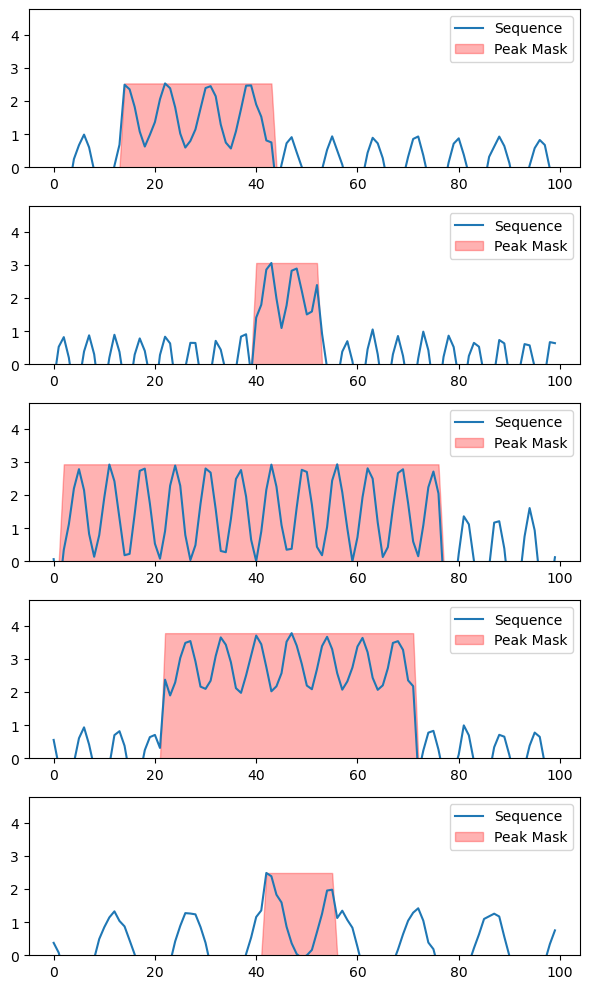

In [57]:
def generate_sequences_and_masks(num_sequences, sequence_length):
    X = np.zeros((num_sequences, sequence_length))
    y = np.zeros((num_sequences, sequence_length))
    
    for i in range(num_sequences):
        # Randomly choose peak start, end, and height
        peak_start = np.random.randint(0, sequence_length // 2)
        peak_end = np.random.randint(peak_start + 1, sequence_length)
        peak_height = np.random.uniform(1, 3)
        
        # Create peak
        X[i, peak_start:peak_end] = peak_height
        y[i, peak_start:peak_end] = 1  # Mark the peak area

        # Add sinusoidal wave to the sequence
        frequency = np.random.uniform(0.05, 0.2)  # Frequency of the wave
        amplitude = np.random.uniform(0.5, 1.5)  # Amplitude of the wave
        phase = np.random.uniform(0, 2 * np.pi)  # Phase shift
        wave = amplitude * np.sin(2 * np.pi * frequency * np.arange(sequence_length) + phase)
        X[i] += wave
        
        # Add random noise
        noise_level = 0.1
        noise = noise_level * np.random.randn(sequence_length)
        X[i] += noise
    
    return X, y

def visualize_sequences(X, y):
    num_sequences = X.shape[0]
    plt.figure(figsize=(6, num_sequences * 2))
    
    for i in range(num_sequences):
        plt.subplot(num_sequences, 1, i+1)
        plt.plot(X[i], label='Sequence')
        plt.fill_between(range(len(y[i])), 0, y[i] * np.max(X[i]), color='red', alpha=0.3, label='Peak Mask')
        plt.legend()
        plt.ylim(0, np.max(X) + 1)
    
    plt.tight_layout()
    plt.show()

# Parameters
num_sequences = 5
sequence_length = 100

# Generate data
X, y = generate_sequences_and_masks(num_sequences, sequence_length)

# Visualization
visualize_sequences(X, y)

As you can see task can not be solved by a trivial thresholding. It would require some clever tricks to come up with an algorithm to achieve the desired result. Let's instead try to achieve that using a model.

Main trick of U-Net is compression with skip connections

<img width=60% src="https://pub.mdpi-res.com/remotesensing/remotesensing-12-02001/article_deploy/html/images/remotesensing-12-02001-ag.png"/>

In our case we are dealing with 1D sequence, but the idea stays the same: use CNN with stride to compress, then use deconvolution and concatenate with matching layer from before.

In [62]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.down1 = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.down2 = nn.Sequential(
            nn.Conv1d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.up1 = nn.Sequential(
            nn.ConvTranspose1d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU()
        )
        self.out_conv = nn.Conv1d(32, 1, kernel_size=3, padding=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder
        x1 = self.down1(x)
        x2 = self.down2(x1)
        
        # Decoder
        x3 = self.up1(x2)

        # Concatenate along the channel dimension
        x3 = torch.cat((x3, x1), dim=1)  
        
        # Passing through the final layers
        x4 = self.out_conv(x3)
        return self.sigmoid(x4)

model = UNet()

To visualize the model you can save it as onnx and then open it using Netron.

```python
import torch.onnx

dummy_input = torch.randn(1, 1, 100)
torch.onnx.export(model, dummy_input, "unet_model.onnx")
```

This should give you

<img width=20% src="https://raw.githubusercontent.com/trokas/ai_primer/master/img/u-net.png"/>

In [59]:
# Generate data
X, y = generate_sequences_and_masks(200, 100)
# We have to add extra dimension for CNNs and convert to torch tensors
X = torch.tensor(X[:, np.newaxis, :], dtype=torch.float32)
y = torch.tensor(y[:, np.newaxis, :], dtype=torch.float32)

# Create DataLoader
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

In [60]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
for epoch in range(num_epochs):
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.5489223003387451
Epoch 2, Loss: 0.34984028339385986
Epoch 3, Loss: 0.12711112201213837
Epoch 4, Loss: 0.05468541756272316
Epoch 5, Loss: 0.10239103436470032
Epoch 6, Loss: 0.09671585261821747
Epoch 7, Loss: 0.11851236969232559
Epoch 8, Loss: 0.09198583662509918
Epoch 9, Loss: 0.04309234395623207
Epoch 10, Loss: 0.09712385386228561
Epoch 11, Loss: 0.04905369505286217
Epoch 12, Loss: 0.0534295029938221
Epoch 13, Loss: 0.04960276558995247
Epoch 14, Loss: 0.09613198786973953
Epoch 15, Loss: 0.06632597744464874
Epoch 16, Loss: 0.09436706453561783
Epoch 17, Loss: 0.09682081639766693
Epoch 18, Loss: 0.05923569202423096
Epoch 19, Loss: 0.060930199921131134
Epoch 20, Loss: 0.07364819198846817


Let's see how our predictions look like.

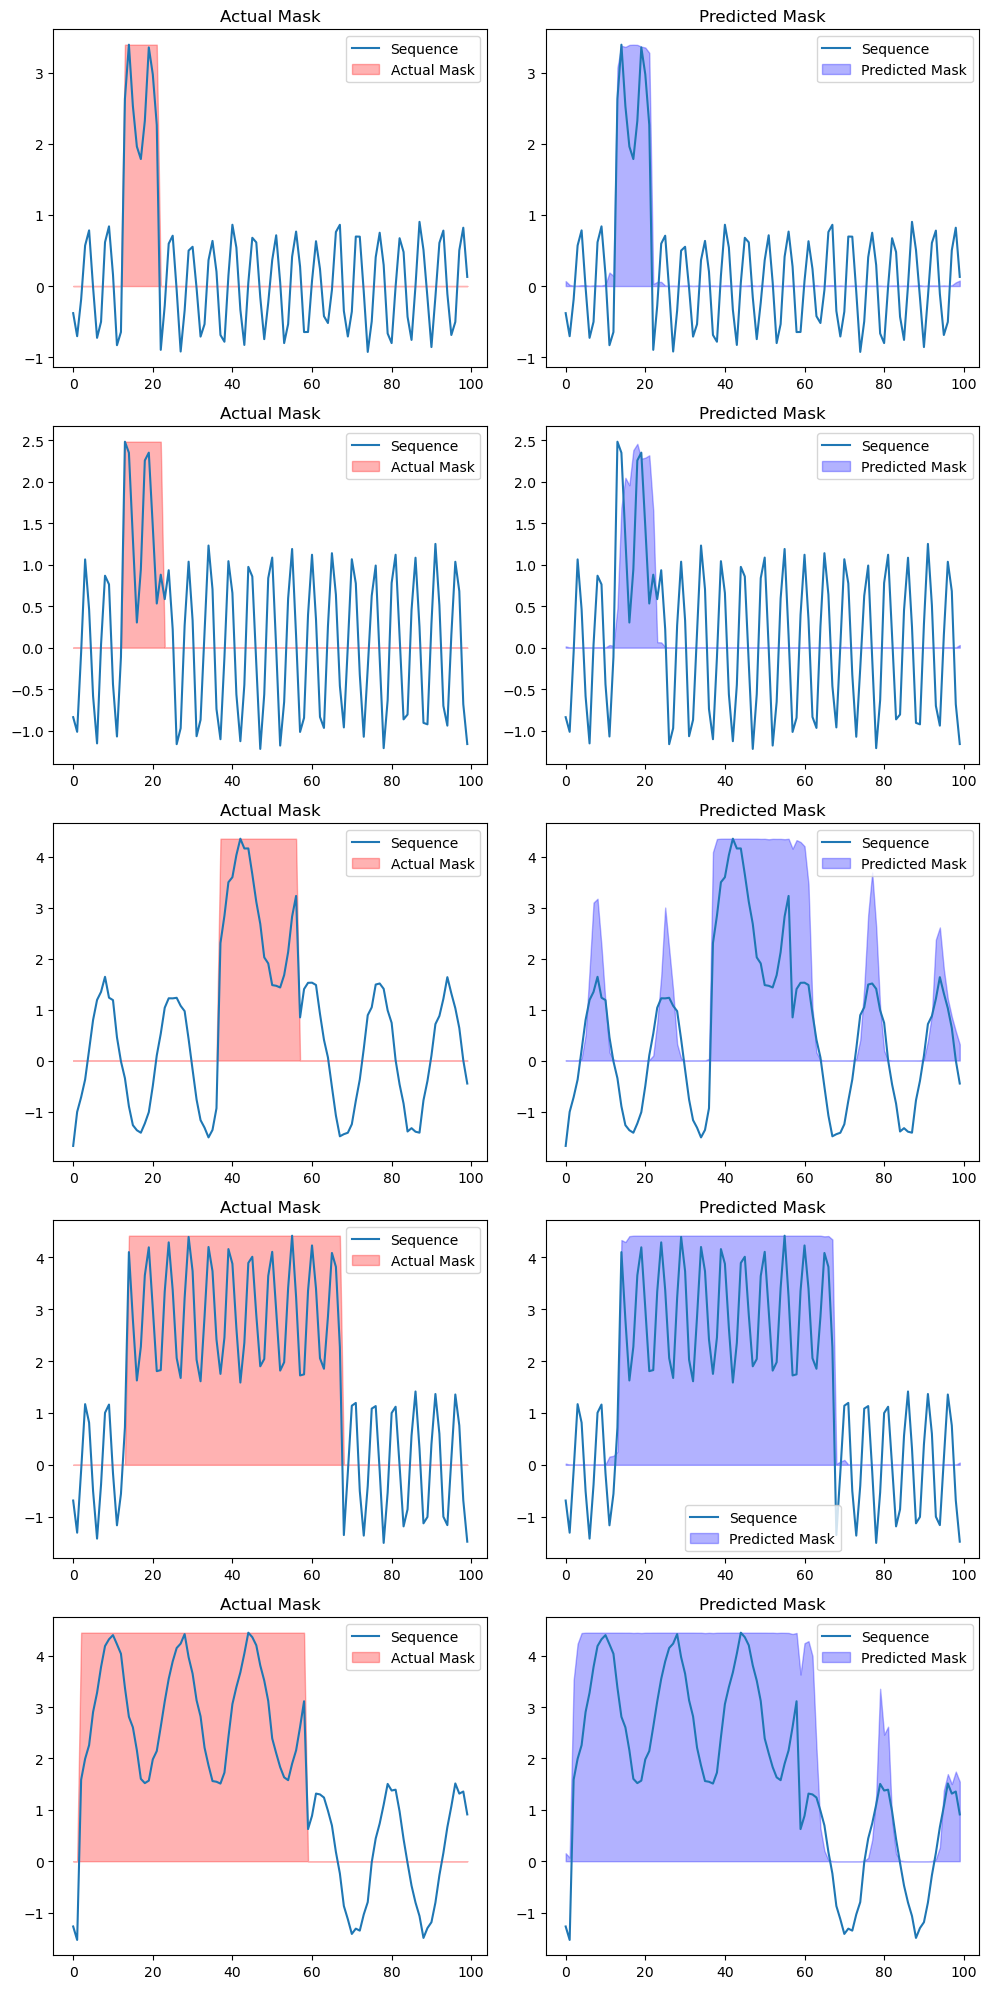

In [61]:
def visualize_predictions(X, y, model):
    model.eval()
    with torch.no_grad():
        # Ensure that X is properly formatted as a float tensor and add channel dimension if necessary
        if X.dim() == 2:  # If X is [sequence_length, num_features] shape
            X = X.unsqueeze(1)  # Reshape to [sequence_length, 1, num_features] if necessary
        predictions = model(X)

    num_sequences = X.shape[0]
    plt.figure(figsize=(10, num_sequences * 4))
    
    for i in range(num_sequences):
        plt.subplot(num_sequences, 2, 2 * i + 1)
        plt.plot(X[i, 0].numpy(), label='Sequence')
        plt.fill_between(range(X.shape[2]), 0, y[i, 0].numpy() * np.max(X[i, 0].numpy()), color='red', alpha=0.3, label='Actual Mask')
        plt.legend()
        plt.title('Actual Mask')

        plt.subplot(num_sequences, 2, 2 * i + 2)
        plt.plot(X[i, 0].numpy(), label='Sequence')
        plt.fill_between(range(X.shape[2]), 0, predictions[i, 0].numpy() * np.max(X[i, 0].numpy()), color='blue', alpha=0.3, label='Predicted Mask')
        plt.legend()
        plt.title('Predicted Mask')
    
    plt.tight_layout()
    plt.show()

X_vis, y_vis = X[:5], y[:5]  # select the first 5 for visualization
visualize_predictions(X_vis, y_vis, model)

U-Nets are known to work pretty well with limites datasets and as you can see it worked out really nicely here.

## (re)Sources
- [Video explanation of CNN's](https://deeplizard.com/learn/video/YRhxdVk_sIs)
- [Top 10 architectures](https://towardsdatascience.com/illustrated-10-cnn-architectures-95d78ace614d)
- Crazy example of how filters (convolutionas) can be used - [Neural Celural Automata](https://distill.pub/2020/growing-ca/)